# Analýza shromážděných účastnických dat pro AmKon 2023 prostřednictvím systému AmKonApp
*autor: Martin Gráf*

*\*K analýze byla využita data z databáze AmKonApp k datu 17.9.2023.*

In [36]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings
import plotly.graph_objects as gp

In [37]:
def removeSensitiveColumns(d: pd.DataFrame):
    d.drop('Číslo průkazu',axis='columns', inplace=True, errors='ignore')

In [38]:
def removeAdminsAndOrgs(d: pd.DataFrame) -> pd.DataFrame:
    attendees = d.loc[d['Přístupová práva'].isin(['Účastník', 'Přihlášený'])]
    # loggedIn = d[d['Přístupová práva'] == ]
    return attendees

In [39]:
def constructRegistrationsWithUserFields(users: pd.DataFrame, registrations: pd.DataFrame) -> pd.DataFrame:
    amendedRegistrations = registrations
    amendedRegistrations['Pohlaví'] = 'Jiné'
    for reg in amendedRegistrations.index:
        currentItem = amendedRegistrations.loc[reg]
        correspondingUser = users.loc[users['Id'] == currentItem['Id']].iloc[0]
        amendedRegistrations.at[reg, 'Pohlaví'] = correspondingUser['Pohlaví']
    return amendedRegistrations

In [40]:
def constructTransactionsWithUserAndRegFields(users: pd.DataFrame, registrations: pd.DataFrame, transactions: pd.DataFrame) -> pd.DataFrame:
    amendedTransactions = transactions

    amendedTransactions['Pohlaví odesílatele'] = ''
    amendedTransactions['Strana odesílatele'] = ''
    amendedTransactions['Typ pozice odesílatele'] = ''

    amendedTransactions['Pohlaví příjemce'] = ''
    amendedTransactions['Strana příjemce'] = ''
    amendedTransactions['Typ pozice příjemce'] = ''

    for tran in amendedTransactions.index:
        currentItem = amendedTransactions.loc[tran]

        correspondingSender = users.loc[users['Id'] == currentItem['Provedl']]
        correspondingReciever = users.loc[users['Jméno'] == currentItem['Příjemce']]

        if len(correspondingSender) > 0:
            correspondingSender = correspondingSender.iloc[0]
            #correspondingSenderReg = registrations.loc[correspondingSender['Id'] == registrations['Id']].iloc[0]
            amendedTransactions.at[tran, 'Pohlaví odesílatele'] = correspondingSender['Pohlaví']
            amendedTransactions.at[tran, 'Strana odesílatele'] = correspondingSender['Strana']
            if not pd.isna(correspondingSender['Pozice']):
                if correspondingSender['Pozice'].startswith('Lobista'):
                    amendedTransactions.at[tran, 'Typ pozice odesílatele'] = 'Lobby'
                elif correspondingSender['Pozice'].startswith('Poslanec'):
                    amendedTransactions.at[tran, 'Typ pozice odesílatele'] = 'House'
                elif correspondingSender['Pozice'].startswith('Senátor'):
                    amendedTransactions.at[tran, 'Typ pozice odesílatele'] = 'Senate'

        if len(correspondingReciever) > 0:
            correspondingReciever = correspondingReciever.iloc[0]
            #correspondingRecieverReg = registrations.loc[correspondingReciever['Id'] == registrations['Id']].iloc[0]
            amendedTransactions.at[tran, 'Pohlaví příjemce'] = correspondingReciever['Pohlaví']
            amendedTransactions.at[tran, 'Strana příjemce'] = correspondingReciever['Strana']
            if not pd.isna(correspondingReciever['Pozice']):
                if correspondingReciever['Pozice'].startswith('Lobista'):
                    amendedTransactions.at[tran, 'Typ pozice příjemce'] = 'Lobby'
                elif correspondingReciever['Pozice'].startswith('Poslanec'):
                    amendedTransactions.at[tran, 'Typ pozice příjemce'] = 'House'
                elif correspondingReciever['Pozice'].startswith('Senátor'):
                    amendedTransactions.at[tran, 'Typ pozice příjemce'] = 'Senate'

    return amendedTransactions

In [41]:
def constructPyramidPercentDataframe(originData: pd.DataFrame, categories: list, categoricalColumn: str, binaryColumn: str, binary1: str, binary2: str) -> pd.DataFrame:
    set1 = originData[originData[binaryColumn] == binary1]
    set2 = originData[originData[binaryColumn] == binary2]
    distribution = pd.DataFrame({categoricalColumn: categories, 
                                    binary1: [set1[set1[categoricalColumn] == i].shape[0] for i in categories],
                                    binary2: [set2[set2[categoricalColumn] == i].shape[0] for i in categories]})
    sum2 = distribution[binary2].sum()
    sum1 = distribution[binary1].sum()
    if sum2 > 0:
        set2Percent = 100/sum2
    else:
        set2Percent = 1

    if sum1 > 0:
        set1Percent = 100/sum1
    else:
        set1Percent = 1

    for i in range(len(distribution)):
        distribution[binary1][i] = distribution[binary1][i]*set1Percent
        distribution[binary2][i] = distribution[binary2][i]*set2Percent
    distribution[binary2] = distribution[binary2] * (-1)
    return distribution

In [42]:
users = pd.read_csv('data/2023/export.csv')
registrations = pd.read_csv('data/2023/registrace.csv')
transactions = pd.read_csv('data/2023/transakce.csv')

warnings.simplefilter(action='ignore', category=FutureWarning)

In [43]:
genders = ['Muž', 'Žena', 'Jiné']
schoolVals = ['2. ročník SŠ a nižší', '3. ročník SŠ', '4. ročník SŠ', 'bakalářské studium', 'magisterské studium']
congressBodies = ['Government', 'TCK', 'Lobby', 'Senate', 'House']
committees = ['Výbor pro justici', 'Výbor pro ozbrojené složky', 'Výbor pro zahraniční vztahy', 'Výbor pro národní bezpečnost', 
 'Výbor pro klimatickou krizi', 'Výbor pro energetiku a hospodářství', 'Výbor pro biotechnologie a výzkum', 'Výbor pro sociální služby']

Z celkem 139 přijatých účastníků bylo 90 mužů a 48 žen, spolu s 1 příslušníkem jiného pohlaví.


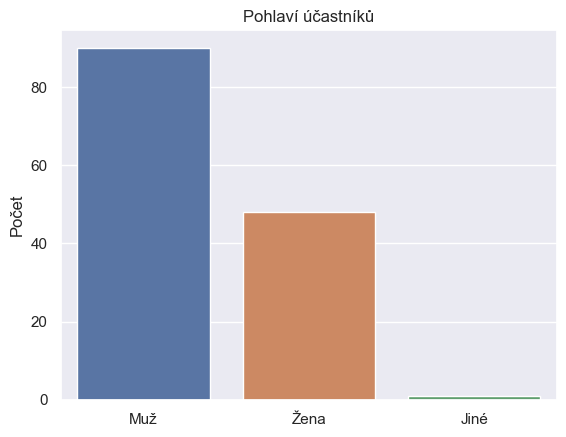

In [44]:
removeSensitiveColumns(users)
nonOrgs = removeAdminsAndOrgs(users)
sns.set(font_scale=1)
user_hist = sns.countplot(x=nonOrgs['Pohlaví'], data=nonOrgs, order=genders)
print('Z celkem {} přijatých účastníků bylo {} mužů a {} žen, spolu s {} příslušníkem jiného pohlaví.'
      .format(nonOrgs[nonOrgs['Pohlaví'].isin(genders)].shape[0], nonOrgs[nonOrgs['Pohlaví'] == 'Muž'].shape[0], nonOrgs[nonOrgs['Pohlaví'] == 'Žena'].shape[0], 
              nonOrgs[nonOrgs['Pohlaví'] == 'Jiné'].shape[0]))
plt.title('Pohlaví účastníků')
plt.ylabel('Počet')
plt.xlabel('')
plt.show(user_hist)


Vzhledem k minimálnímu množství příslušníků jiného pohlaví budou vynecháni při porovnávání vlastností jednotlivých skupin podle pohlaví, budou ovšem zahrnuti v jiných metrikách.

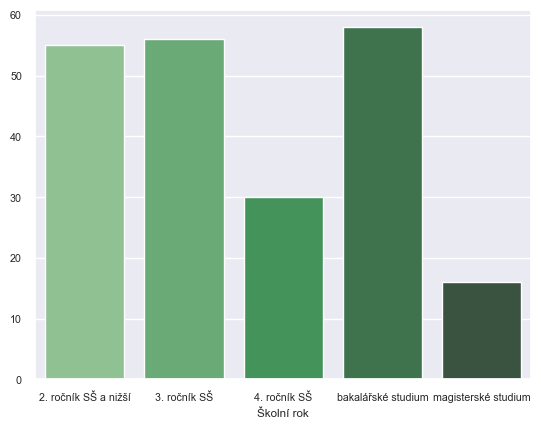

In [45]:
pairedRegs = constructRegistrationsWithUserFields(users=nonOrgs, registrations=registrations)
sns.set(font_scale=0.7)
fig = sns.countplot(x=pairedRegs['Školní rok'], order=schoolVals, data=pairedRegs, palette="Greens_d")
plt.ylabel("")
plt.show(fig)

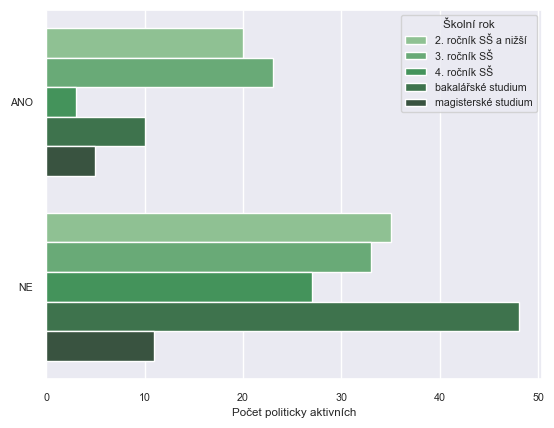

In [46]:
fig = sns.countplot(y=pairedRegs['Člen politické strany'], data=pairedRegs, hue=pairedRegs['Školní rok'], hue_order=schoolVals, palette="Greens_d")
plt.ylabel("")
plt.xlabel("Počet politicky aktivních")
plt.show(fig)

In [47]:
schoolDistribution = constructPyramidPercentDataframe(originData=pairedRegs, categories=schoolVals, categoricalColumn='Školní rok', binaryColumn='Pohlaví', binary1='Muž', binary2='Žena')

C:\Users\margr\AppData\Local\Temp\ipykernel_21984\2371379105.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\margr\AppData\Local\Temp\ipykernel_21984\2371379105.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [48]:
fig = gp.Figure()

fig.add_trace(gp.Bar(y= schoolDistribution['Školní rok'], x = schoolDistribution['Muž'], 
                     name = 'Muži', 
                     orientation = 'h'))

fig.add_trace(gp.Bar(y = schoolDistribution['Školní rok'], x = schoolDistribution['Žena'],
                     name = 'Ženy', orientation = 'h'))

fig.update_layout(title = 'Rozdělení vzdělání podle pohlaví',
                 title_font_size = 22, barmode = 'relative',
                 bargap = 0.0, bargroupgap = 0,
                 xaxis = dict(tickvals = [-30, -20, -10,
                                          0, 10, 20, 30],
                                
                              ticktext = ['30%', '20%', '10%', '0%', 
                                          '10%', '20%', '30%'],
                                
                              title_font_size = 14)
                 )
  
fig.show()

In [49]:
schoolPoliticsDistribution = constructPyramidPercentDataframe(originData=pairedRegs, categories=genders, categoricalColumn='Pohlaví', binaryColumn='Člen politické strany', binary1='ANO', binary2='NE')

C:\Users\margr\AppData\Local\Temp\ipykernel_21984\2371379105.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\margr\AppData\Local\Temp\ipykernel_21984\2371379105.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [50]:
fig = gp.Figure()
fig.add_trace(gp.Bar(y= schoolPoliticsDistribution['Pohlaví'], x = schoolPoliticsDistribution['ANO'], 
                     name = 'Politicky aktivní', 
                     orientation = 'h'))
fig.add_trace(gp.Bar(y = schoolPoliticsDistribution['Pohlaví'], x = schoolPoliticsDistribution['NE'],
                     name = 'Politicky neaktivní', orientation = 'h'))
fig.update_layout(title = 'Rozdělení pohlaví podle členství v politických stranách',
                 title_font_size = 22, barmode = 'relative',
                 bargap = 0.0, bargroupgap = 0,
                 xaxis = dict(tickvals = [-80, -60, -30, -10,
                                          0, 10, 30, 60, 80],
                                
                            ticktext = ['80%', '60%', '30%', '10%', '0%', 
                                          '10%', '30%', '60%', '80%'],
                            title_font_size = 14)
                 )
fig.show()

In [51]:
preferenceDistribution = constructPyramidPercentDataframe(originData=pairedRegs, categories=congressBodies, categoricalColumn='Preferovaná odnož', binaryColumn='Pohlaví', binary1='Muž', binary2='Žena')

C:\Users\margr\AppData\Local\Temp\ipykernel_21984\2371379105.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\margr\AppData\Local\Temp\ipykernel_21984\2371379105.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [52]:
fig = gp.Figure()
fig.add_trace(gp.Bar(y= preferenceDistribution['Preferovaná odnož'], x = preferenceDistribution['Muž'], 
                     name = 'Muži', 
                     orientation = 'h'))
fig.add_trace(gp.Bar(y = preferenceDistribution['Preferovaná odnož'], x = preferenceDistribution['Žena'],
                     name = 'Ženy', orientation = 'h'))
fig.update_layout(title = 'Rozdělení preferencí rolí podle pohlaví',
                 title_font_size = 22, barmode = 'relative',
                 bargap = 0.0, bargroupgap = 0,
                 xaxis = dict(tickvals = [-30, -20, -10,
                                          0, 10, 20, 30],
                            ticktext = ['30%', '20%', '10%', '0%', 
                                          '10%', '20%', '30%'],
                            title="Ženy/Muži",
                            title_font_size = 14)
                 )
fig.show()

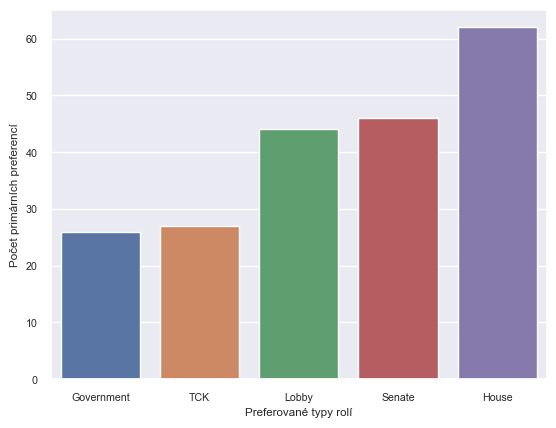

In [53]:
sns.set(font_scale=0.7)
fig = sns.countplot(x=pairedRegs['Preferovaná odnož'], order=congressBodies, data=pairedRegs)
plt.ylabel("Počet primárních preferencí")
plt.xlabel("Preferované typy rolí")
plt.show(fig)

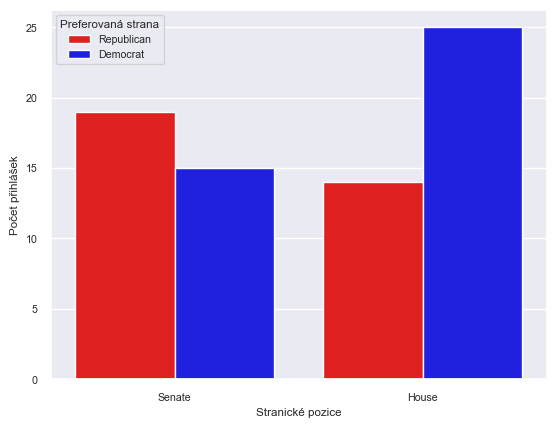

In [54]:
partisianPreferences = pairedRegs[pairedRegs['Preferovaná odnož'].isin(['House', 'Senate'])]
fig = sns.countplot(x=partisianPreferences['Preferovaná odnož'], data=partisianPreferences, hue=partisianPreferences['Preferovaná strana'], palette=['Red','Blue'])
plt.ylabel("Počet přihlášek")
plt.xlabel("Stranické pozice")
plt.show(fig)

In [55]:
partisianDistribution = constructPyramidPercentDataframe(originData=pairedRegs, categories=genders, categoricalColumn='Pohlaví', binaryColumn='Preferovaná strana', binary1='Republican', binary2='Democrat')

C:\Users\margr\AppData\Local\Temp\ipykernel_21984\2371379105.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\margr\AppData\Local\Temp\ipykernel_21984\2371379105.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [56]:
fig = gp.Figure()
fig.add_trace(gp.Bar(y= partisianDistribution['Pohlaví'], x = partisianDistribution['Democrat'], 
                     name = 'Demokraté', 
                     orientation = 'h'))
fig.add_trace(gp.Bar(y = partisianDistribution['Pohlaví'], x = partisianDistribution['Republican'],
                     name = 'Republikáni', orientation = 'h'))
fig.update_layout(title = 'Rozdělení stranických preferencí podle pohlaví',
                 title_font_size = 22, barmode = 'relative',
                 bargap = 0.0, bargroupgap = 0,
                 xaxis = dict(tickvals = [-60, -30, -10,
                                          0, 10, 30, 60],
                              ticktext = ['60%', '30%', '10%', '0%', 
                                          '10%', '30%', '60%'],
                              title_font_size = 14)
                 )
fig.show()

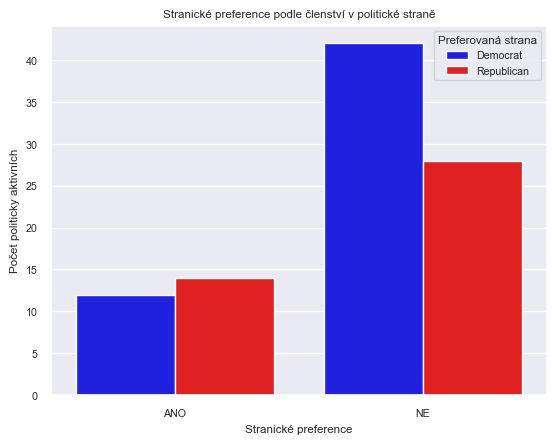

In [57]:
fig = sns.countplot(x=pairedRegs['Člen politické strany'], data=pairedRegs, hue=pairedRegs['Preferovaná strana'], palette=['Blue', 'Red'])
plt.ylabel("Počet politicky aktivních")
plt.xlabel("Stranické preference")
plt.title("Stranické preference podle členství v politické straně")
plt.show(fig)

In [58]:
partisianDistribution = constructPyramidPercentDataframe(originData=pairedRegs, categories=schoolVals, categoricalColumn='Školní rok', binaryColumn='Preferovaná strana', binary1='Republican', binary2='Democrat')

C:\Users\margr\AppData\Local\Temp\ipykernel_21984\2371379105.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\margr\AppData\Local\Temp\ipykernel_21984\2371379105.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [59]:
fig = gp.Figure()
fig.add_trace(gp.Bar(y= partisianDistribution['Školní rok'], x = partisianDistribution['Democrat'], 
                     name = 'Demokraté', 
                     orientation = 'h'))
fig.add_trace(gp.Bar(y = partisianDistribution['Školní rok'], x = partisianDistribution['Republican'],
                     name = 'Republikáni', orientation = 'h'))
fig.update_layout(title = 'Rozdělení stranických preferencí podle vzdělání',
                 title_font_size = 22, barmode = 'relative',
                 bargap = 0.0, bargroupgap = 0,
                 xaxis = dict(tickvals = [-40, -30, -20, -10,
                                          0, 10, 20, 30, 40],
                              ticktext = ['40%', '30%', '20%', '10%', '0%', 
                                          '10%', '20%', '30%', '40%'],
                              title_font_size = 14)
                 )
fig.show()

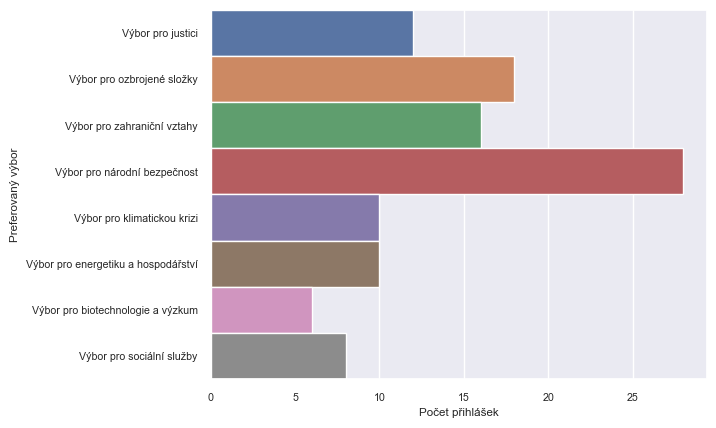

In [60]:
sns.set(font_scale=0.7)
fig = sns.countplot(y=pairedRegs['Preferovaný výbor'], data=pairedRegs, width=1)
plt.ylabel("Preferovaný výbor")
plt.xlabel("Počet přihlášek")
plt.show(fig)

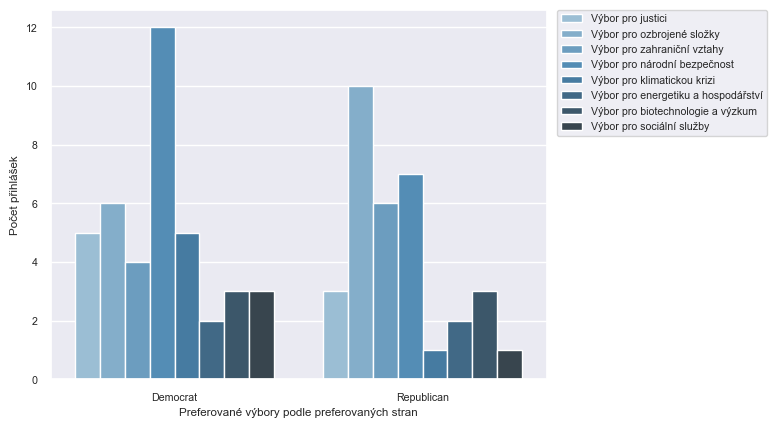

In [61]:
fig = sns.countplot(x=pairedRegs['Preferovaná strana'], data=pairedRegs, hue=pairedRegs['Preferovaný výbor'], palette="Blues_d")
plt.ylabel("Počet přihlášek")
plt.xlabel("Preferované výbory podle preferovaných stran")
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.show(fig)

In [62]:
committeeDistribution = constructPyramidPercentDataframe(originData=pairedRegs, categories=committees, categoricalColumn='Preferovaný výbor', binaryColumn='Pohlaví', binary1='Muž', binary2='Žena')

C:\Users\margr\AppData\Local\Temp\ipykernel_21984\2371379105.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\margr\AppData\Local\Temp\ipykernel_21984\2371379105.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [63]:
fig = gp.Figure()
fig.add_trace(gp.Bar(y= committeeDistribution['Preferovaný výbor'], x = committeeDistribution['Muž'], 
                     name = 'Muži', 
                     orientation = 'h'))
fig.add_trace(gp.Bar(y = committeeDistribution['Preferovaný výbor'], x = committeeDistribution['Žena'],
                     name = 'Ženy', orientation = 'h'))
fig.update_layout(title = 'Rozdělení výborových preferencí podle pohlaví',
                 title_font_size = 22, barmode = 'relative',
                 bargap = 0.0, bargroupgap = 0,
                 xaxis = dict(tickvals = [-40, -30, -20, -10,
                                          0, 10, 20, 30, 40],
                              ticktext = ['40%', '30%', '20%', '10%', '0%', 
                                          '10%', '20%', '30%', '40%'],
                              title_font_size = 14)
                 )
fig.show()

<Axes: >

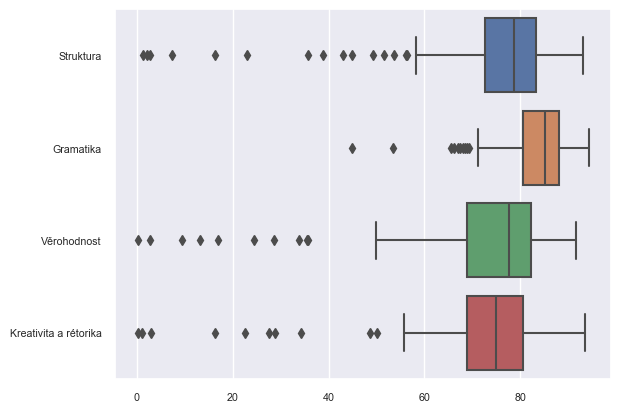

In [64]:
sns.boxplot(data=pairedRegs[["Struktura", "Gramatika", "Věrohodnost", "Kreativita a rétorika"]], orient="h")

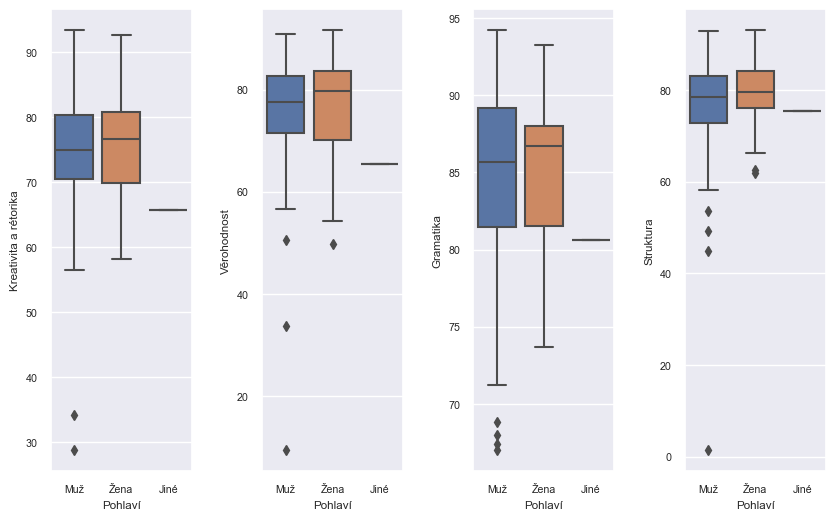

In [65]:
fig, ax = plt.subplots(1, 4, figsize=(10, 6))
sns.boxplot(data=pairedRegs, x="Pohlaví", y="Kreativita a rétorika", ax=ax[0])
sns.boxplot(data=pairedRegs, x="Pohlaví", y="Věrohodnost", ax=ax[1])
sns.boxplot(data=pairedRegs, x="Pohlaví", y="Gramatika", ax=ax[2])
sns.boxplot(data=pairedRegs, x="Pohlaví", y="Struktura", ax=ax[3])
plt.subplots_adjust(wspace=0.5) 
plt.show()

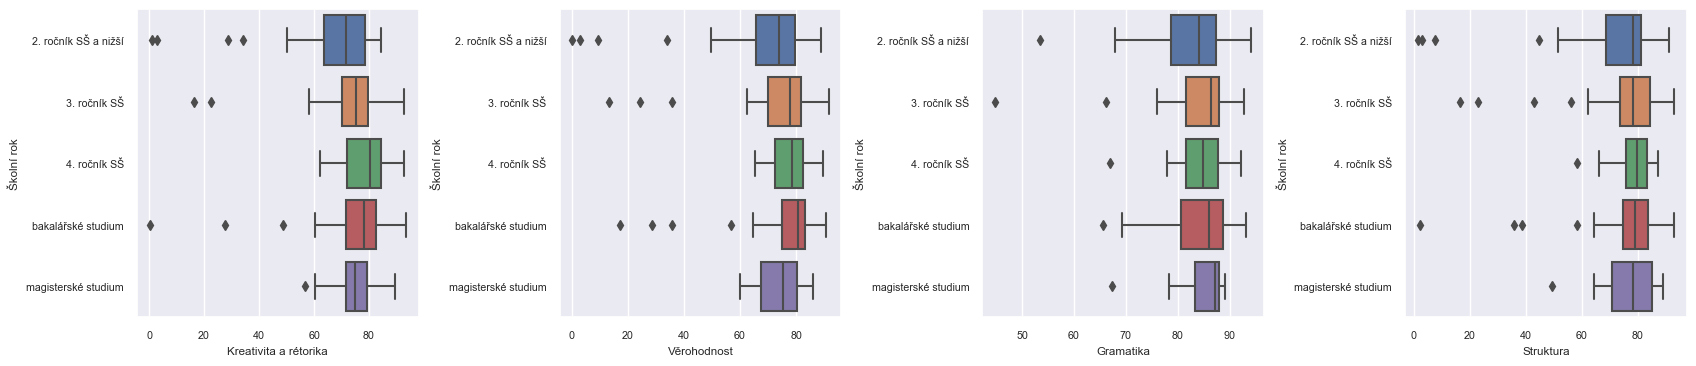

In [66]:
fig, ax = plt.subplots(1, 4, figsize=(20, 4))
sns.boxplot(data=pairedRegs, y="Školní rok", x="Kreativita a rétorika", ax=ax[0], orient="h", order=schoolVals)
sns.boxplot(data=pairedRegs, y="Školní rok", x="Věrohodnost", ax=ax[1], orient="h", order=schoolVals)
sns.boxplot(data=pairedRegs, y="Školní rok", x="Gramatika", ax=ax[2], orient="h", order=schoolVals)
sns.boxplot(data=pairedRegs, y="Školní rok", x="Struktura", ax=ax[3], orient="h", order=schoolVals)
plt.subplots_adjust(wspace=0.5) 
plt.show()

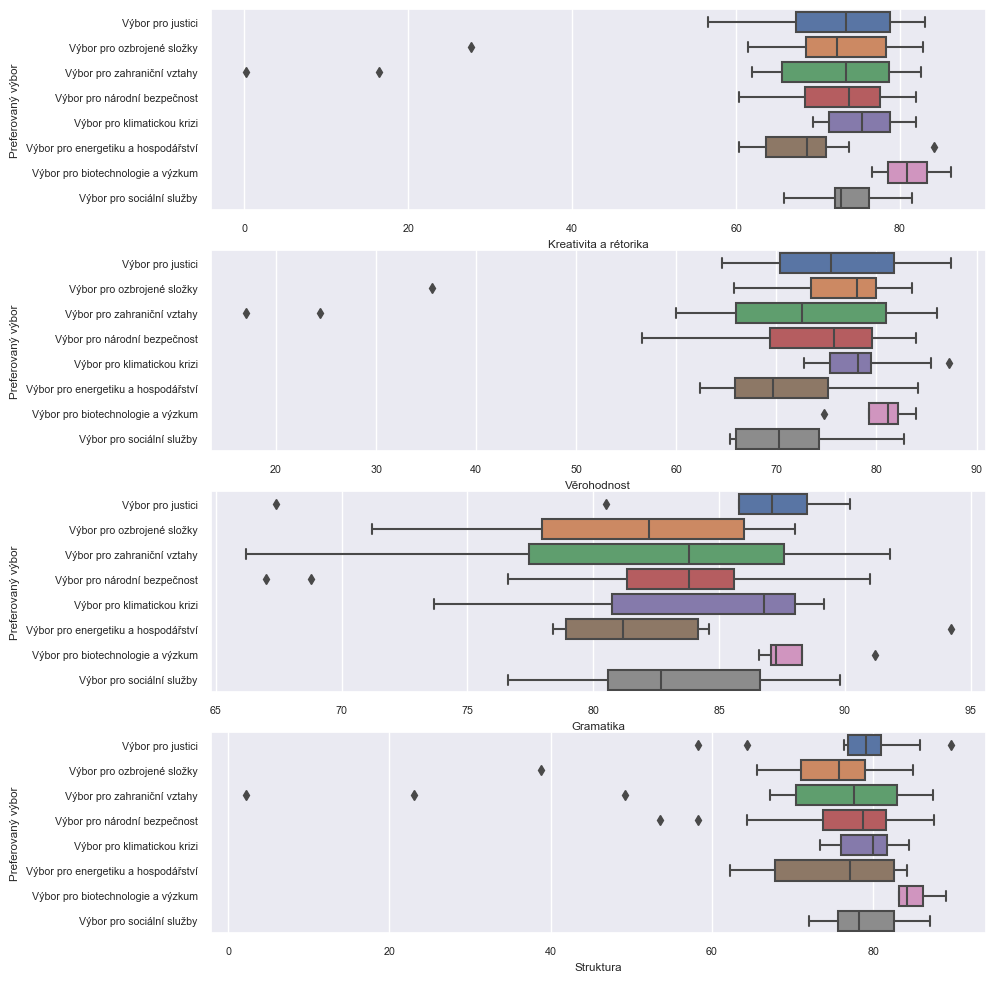

In [67]:
fig, ax = plt.subplots(4, 1, figsize=(10, 12))
sns.boxplot(data=pairedRegs, y="Preferovaný výbor", x="Kreativita a rétorika", ax=ax[0], orient="h")
sns.boxplot(data=pairedRegs, y="Preferovaný výbor", x="Věrohodnost", ax=ax[1], orient="h")
sns.boxplot(data=pairedRegs, y="Preferovaný výbor", x="Gramatika", ax=ax[2], orient="h")
sns.boxplot(data=pairedRegs, y="Preferovaný výbor", x="Struktura", ax=ax[3], orient="h")
plt.subplots_adjust(wspace=0.5) 
plt.show()

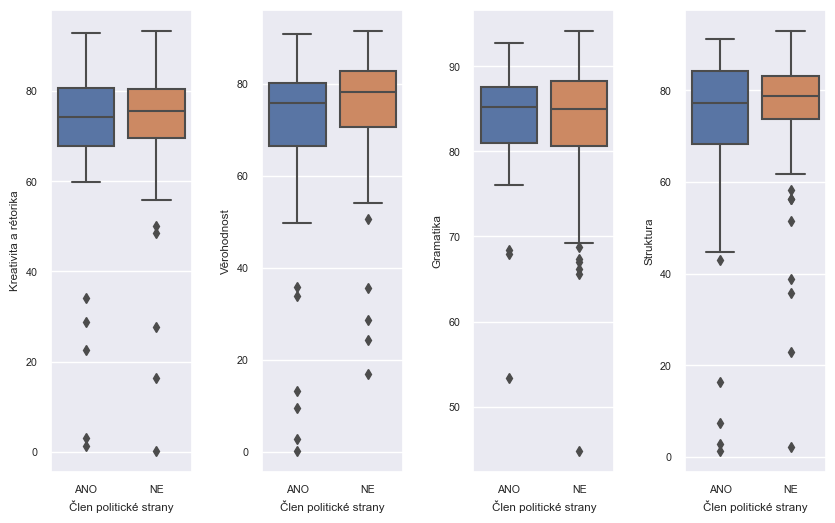

In [68]:
fig, ax = plt.subplots(1, 4, figsize=(10, 6))
sns.boxplot(data=pairedRegs, x='Člen politické strany', y="Kreativita a rétorika", ax=ax[0])
sns.boxplot(data=pairedRegs, x='Člen politické strany', y="Věrohodnost", ax=ax[1])
sns.boxplot(data=pairedRegs, x='Člen politické strany', y="Gramatika", ax=ax[2])
sns.boxplot(data=pairedRegs, x='Člen politické strany', y="Struktura", ax=ax[3])
plt.subplots_adjust(wspace=0.5) 
plt.show()

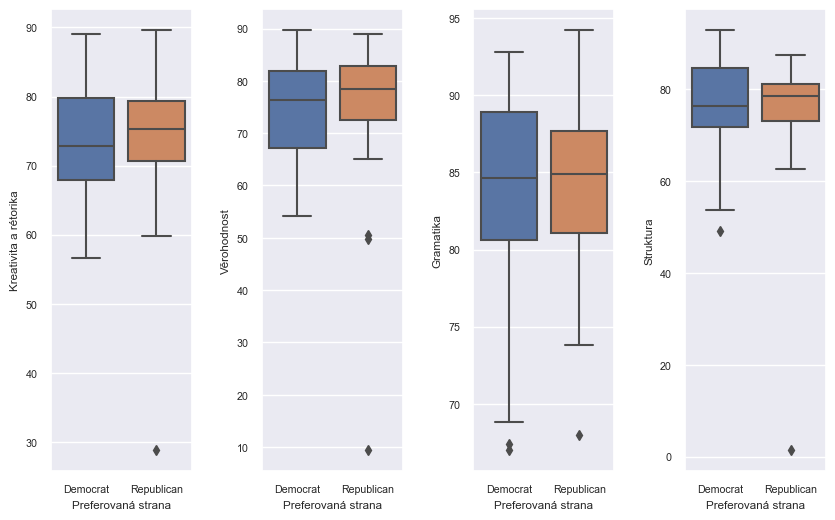

In [69]:
fig, ax = plt.subplots(1, 4, figsize=(10, 6))
sns.boxplot(data=pairedRegs, x='Preferovaná strana', y="Kreativita a rétorika", ax=ax[0])
sns.boxplot(data=pairedRegs, x='Preferovaná strana', y="Věrohodnost", ax=ax[1])
sns.boxplot(data=pairedRegs, x='Preferovaná strana', y="Gramatika", ax=ax[2])
sns.boxplot(data=pairedRegs, x='Preferovaná strana', y="Struktura", ax=ax[3])
plt.subplots_adjust(wspace=0.5) 
plt.show()

In [70]:
pairedTrans = constructTransactionsWithUserAndRegFields(users=nonOrgs, registrations=registrations, transactions=transactions)
pairedTrans

,Čas,Částka,Příjemce,Odesílatel,Poznámka,Provedl,Provedl - jméno,Sesterská transakce - jméno příjemce,Pohlaví odesílatele,Strana odesílatele,Typ pozice odesílatele,Pohlaví příjemce,Strana příjemce,Typ pozice příjemce
0,11. 9. 11:41,850000.0,CCTV America (China Central Television),Martin Graf,NaN,LcxaW4aDIVboADkzm9ICbUxBbpf1,Martin Graf,NaN,,,,,,House
1,11. 9. 11:42,850000.0,Honeywell,Martin Graf,NaN,LcxaW4aDIVboADkzm9ICbUxBbpf1,Martin Graf,NaN,,,,,,House
2,11. 9. 11:42,870000.0,ConocoPhillips,Martin Graf,NaN,LcxaW4aDIVboADkzm9ICbUxBbpf1,Martin Graf,NaN,,,,,,House
3,11. 9. 11:43,900000.0,General Electric,Martin Graf,NaN,LcxaW4aDIVboADkzm9ICbUxBbpf1,Martin Graf,NaN,,,,,,House
4,11. 9. 11:44,920000.0,AT&T,Martin Graf,NaN,LcxaW4aDIVboADkzm9ICbUxBbpf1,Martin Graf,NaN,,,,,,House
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
728,15. 9. 9:17,10000.0,Karolína Zemanová,Union of Concerned Scientists,NaN,zJiSH02zp9d4nJvIpULn97gpiax1,Klára Hájková,Koalice za udržitelnou energetiku a životní pr...,Žena,NaN,Lobby,Žena,Democrat,House
729,15. 9. 9:17,10000.0,Koalice za udržitelnou energetiku a životní pr...,Union of Concerned Scientists,NaN,zJiSH02zp9d4nJvIpULn97gpiax1,Klára Hájková,Karolína Zemanová,Žena,NaN,Lobby,,,House
730,15. 9. 10:54,0.0,Hudson Institute,Hudson Institute,Sláva prezidentce Ondráčkové,4Utclv5oWrc30ZPMKq8gip9yZQZ2,Jakub Zbýtovský,NaN,,,,,,House
731,15. 9. 11:01,20000.0,CCTV America (China Central Television),Uskupení pro oblast ASEAN,reverting transaction 4f4b9929-fc3b-4777-a958-...,GgKibYbDGOTE5dwyIiSrgpx8neA3,Pavel Koutný,NaN,Muž,Republican,House,,,House
